<a href="https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This example demonstrates video classification. It is an important use-case with applications in surveillance, security, and so on. We will be using the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php) to build our video classifier. The dataset consists of videos categorized into different actions like cricket shot, punching, biking, etc. This is why the dataset is known to build action recognizers which is just an extension of video classification.

A video is made of an ordered sequence of frames. While the frames constitue **spatiality** the sequence of those frames constitute the **temporality** of a video. To systematically model both of these aspects we generally use a hybrid architecture that consists of convolutions (for spatiality) as well as recurrent layers (for temporality). In this example, we will be using such a hybrid architecture consisting of a Convolutional Neural Network (CNN) and a Recurrent Neural Network (RNN) consisting of [GRU layers](https://keras.io/api/layers/recurrent_layers/gru/). These kinds of hybrid architectures are popularly known as **CNN-RNN**. 

This example requires TensorFlow 2.4 or higher, as well as TensorFlow Docs, which can be installed using the following command:

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 6.9MB/s 


## Data collection

In order to keep the runtime of this example relatively short, we will be using a subsampled version of the original UCF101 dataset. You can refer to [this notebook](https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb) to know how the subsampling was done. 

In [2]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## Setup

In [3]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np
import imageio
import cv2
import os

## Define hyperparameters

In [4]:
EPOCHS = 100
BATCH_SIZE = 64
IMG_SIZE = 224

SEQ_LENGTH = 5

## Data preparation

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 594
Total videos for testing: 224


In [6]:
train_df.sample(10)

,video_name,tag
6,v_CricketShot_g08_c07.avi,CricketShot
347,v_Punch_g24_c03.avi,Punch
226,v_PlayingCello_g24_c03.avi,PlayingCello
307,v_Punch_g18_c02.avi,Punch
374,v_ShavingBeard_g10_c02.avi,ShavingBeard
560,v_TennisSwing_g20_c03.avi,TennisSwing
524,v_TennisSwing_g14_c07.avi,TennisSwing
299,v_Punch_g17_c01.avi,Punch
555,v_TennisSwing_g19_c04.avi,TennisSwing
371,v_ShavingBeard_g09_c06.avi,ShavingBeard


One of the many challenges of training video classifiers is figuring out a way to feed the videos to a network. [This blog post](https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5https://) discusses five such methods. As a video is an ordered sequence of frames, we can extract the frames, organize them, and then feed them to our network. But the number of frames may differ which would not allow mini-batch learning. To account for all these factors, we can do the following:

1. Capture the frames of a video. 
2. Save the frames within a predefined serialization interval until a maximum frame count is reached.

Videos of the UCF101 dataset is [known](https://www.crcv.ucf.edu/papers/UCF101_CRCV-TR-12-01.pdf) to not contain extreme variations in objects and actions across frames. Because of this, it is okay to only consider a few frames for the learning task. We will be using [OpenCV's `VideoCapture()` method](https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html) to read frames from videos. 

In [7]:
def separate_frames(video_names, root_dir, output_dir, 
                    frame_count=SEQ_LENGTH, save_interval=10):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    
    broken_video_names = []

    for video_name in tqdm(video_names):
        count = 0
        video_path = os.path.join(root_dir, video_name)
        cap = cv2.VideoCapture(video_path) 
        nb_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) 
        
        try:
            while True:
                (grabbed, frame) = cap.read()
                # Check if OpenCV was able to start reading the frames and
                # if not, then break. 
                if not grabbed:
                    broken_video_names.append(video_name)
                    break
                if count == frame_count:
                    break
                if nb_frames % save_interval == 0:
                    frame_name = video_name.split(".")[0] + "_frame%d.jpg" % count
                    filename = os.path.join(output_dir, frame_name)
                    count += 1
                    cv2.imwrite(filename, frame)
        finally:
            cap.release()

    return broken_video_names

In [8]:
train_video_names = train_df["video_name"].values.tolist()
test_video_names = test_df["video_name"].values.tolist()

broken_video_names_train = separate_frames(train_video_names, "train", "train_frames")
broken_video_names_test = separate_frames(test_video_names, "test", "test_frames")

100%|██████████| 224/224 [00:06<00:00, 34.33it/s]


Now that we have extracted the frames and serialized them we can organize them in a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for easy information retrieval. 

In [9]:
def create_df(dir):
    images = sorted(list(paths.list_images(dir)))
    images_paths = []
    classes = []
    for i in tqdm(range(len(images))):
        images_paths.append(dir + "/" + images[i].split('/')[1])
        classes.append(images[i].split('/')[1].split('_')[1])

    new_df = pd.DataFrame()
    new_df["image_path"] = images_paths
    new_df["class"] = classes

    return new_df

In [10]:
new_train_df = create_df("train_frames")
new_test_df = create_df("test_frames")

print()
print(f"Total number of training frames: {len(new_train_df)}")
print(f"Total number of testing frames: {len(new_test_df)}")

100%|██████████| 170/170 [00:00<00:00, 309879.04it/s]


Total number of training frames: 760
Total number of testing frames: 170


In [11]:
new_train_df.head(10)

,image_path,class
0,train_frames/v_CricketShot_g09_c07_frame0.jpg,CricketShot
1,train_frames/v_CricketShot_g09_c07_frame1.jpg,CricketShot
2,train_frames/v_CricketShot_g09_c07_frame2.jpg,CricketShot
3,train_frames/v_CricketShot_g09_c07_frame3.jpg,CricketShot
4,train_frames/v_CricketShot_g09_c07_frame4.jpg,CricketShot
5,train_frames/v_CricketShot_g10_c05_frame0.jpg,CricketShot
6,train_frames/v_CricketShot_g10_c05_frame1.jpg,CricketShot
7,train_frames/v_CricketShot_g10_c05_frame2.jpg,CricketShot
8,train_frames/v_CricketShot_g10_c05_frame3.jpg,CricketShot
9,train_frames/v_CricketShot_g10_c05_frame4.jpg,CricketShot


## Feature extraction from frames

We can use a pre-trained network to extract meaningful features from the extracted frames. The [`Applications`](https://keras.io/api/applications/) class of Keras provides a number of state-of-the-art models pre-trained on the [ImageNet-1k dataset](http://image-net.org/). We will be using the [InceptionV3 model](https://arxiv.org/abs/1512.00567) for this purpose. 

After extracting the features, we need to feed them to a recurrent network considering the temporality present inside of them. Data fed to the recurrent layers must have a time-step dimension. So, how do we incorporate that in the extracted features? 

The extracted features will have a shape of `(len(frames), 2048)` (after pooling). Recall that each video is now represented as an ordered sequence of five frames. So, we can reshape our features like so: `len(train_frames)/SEQ_LENGTH, SEQ_LENGTH, 2048)`. The second dimension (`SEQ_LENGTH`) is now the time-step dimension. It turns out that this heuristic works quite well in practice. It just needs as adjustment in the number of examples such that it is divisible by the number of frames representing a video. Fortunately, for this example, we will not have to do that explicitly. 

To account for all these, we will:

1. Start by representing the available videos to have a shape of `(len(frames), IMG_SIZE, IMG_SIZE, 3)`.
2. Pass the tensor created in Step 1 to our feature extractor module. 

In [12]:
def gather_single_video(df, root_index):
    temp_sequence = np.empty((SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3))

    for i in range(SEQ_LENGTH):
        frame_path = df.iloc[root_index + i]["image_path"]
        image = keras.preprocessing.image.load_img(frame_path, target_size=(IMG_SIZE, IMG_SIZE))
        image = keras.preprocessing.image.img_to_array(image)
        temp_sequence[i, ] = image

    return temp_sequence

def prepare_sequences(df):
    # shape: (num_frames/5, 5, 224, 224, 3)
    # The only constraint here is the length of the input DataFrame should be
    # divisible by `SEQ_LENGTH`.
    sequences = np.empty((len(df)//SEQ_LENGTH, SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3))
    
    for i, idx in enumerate(range(0, len(df), SEQ_LENGTH)):
        temp_sequence = gather_single_video(df, root_index=idx)
        sequences[i, ] = temp_sequence
    
    return sequences

In [13]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(weights="imagenet", include_top=False, pooling="avg",
                                                       input_shape=(IMG_SIZE, IMG_SIZE, 3))
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3))
    # We make use of `TimeDistributed` layers here to account for the time-step
    # dimension.
    preprocessed = keras.layers.TimeDistributed(keras.layers.Lambda(preprocess_input))(inputs)

    outputs = keras.layers.TimeDistributed(feature_extractor)(preprocessed)
    outputs_flat = keras.layers.Reshape((SEQ_LENGTH, -1))(outputs)
    
    return keras.Model(inputs, outputs_flat, name="feature_extractor")

In [14]:
# Prepare the videos as an ordered sequence. 
train_sequence = prepare_sequences(new_train_df)
test_sequence = prepare_sequences(new_test_df)
print(train_sequence.shape, test_sequence.shape)

(152, 5, 224, 224, 3) (34, 5, 224, 224, 3)


In [15]:
# Extract features from the video frames.
feature_extractor = build_feature_extractor()

train_features = feature_extractor.predict(train_sequence)
test_features = feature_extractor.predict(test_sequence)
print(train_features.shape, test_features.shape)

87916544/87910968 [==============================] - 0s 0us/step
(152, 5, 2048) (34, 5, 2048)


## Prepare labels

We now need to prepare the labels i.e. the action classes which are present as strings. Neural networks do not understand string values, they must be converted to some numerical form before they are fed to neural networks. Here we will use the [`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup) layer to binarize the string class labels. It will first give us an integer encoding of the string values and then it will [one-hot encode](https://developers.google.com/machine-learning/glossary#one-hot-encoding) those values. The point of making the values one-hot encoded will be made clear in a moment. 

We first need to skip some labels from both train and test sets since the number of samples has changed now. 

In [16]:
def prepare_labels(df):
    labels = []
    
    for i in range(0, len(df), SEQ_LENGTH):
        labels.append(df.iloc[i]["class"])
    return np.stack(labels)

In [17]:
train_labels = prepare_labels(new_train_df)
test_labels = prepare_labels(new_test_df)
print(train_labels.shape, test_labels.shape)

assert len(train_labels) == len(train_features)
assert len(test_labels) == len(test_features)

(152,) (34,)


In [18]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, output_mode="binary",
    vocabulary=np.unique(train_labels)
)

# Represent the labels as one-hot encoded vectors.
train_labels = label_processor(train_labels[..., None])
test_labels = label_processor(test_labels[..., None])
print(train_labels.shape, test_labels.shape)

(152, 5) (34, 5)


In [19]:
# We can verify the vocabulary like so.
class_vocab = label_processor.get_vocabulary()
print(class_vocab)

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


## Train the sequence model

Empirically, [label-smoothing](https://arxiv.org/abs/1906.02629) was found to provide an improved performance. This is why we represented the integer labels as one-hot encoded vectors in the first place. 

In [20]:
# We first shuffle the training data.
train_labels = train_labels.numpy()

rng = np.random.RandomState(123)
rng.shuffle(train_features)
rng = np.random.RandomState(123)
rng.shuffle(train_labels)

In [23]:
# Utility for our sequence model.
def get_sequence_model(optimizer, label_smoothing=0.1): 
    rnn_model = keras.Sequential([
        keras.layers.GRU(16, return_sequences=True),
        keras.layers.GRU(8),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(len(class_vocab), activation="softmax")
    ])
    
    rnn_model.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing), 
                       optimizer=optimizer,
        metrics=["accuracy"])
    return rnn_model

# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, 
                                 save_best_only=True, verbose=1)

    seq_model = get_sequence_model("adam")
    history = seq_model.fit(train_features, train_labels,
        validation_split=0.1,
        epochs=EPOCHS, 
        callbacks=[checkpoint])
    
    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate(test_features, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

Epoch 1/100
5/5 [==============================] - 3s 134ms/step - loss: 1.5335 - accuracy: 0.2647 - val_loss: 1.2416 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 1.24164, saving model to /tmp/video_classifier
Epoch 2/100
5/5 [==============================] - 0s 9ms/step - loss: 1.3220 - accuracy: 0.4853 - val_loss: 1.1791 - val_accuracy: 0.8125

Epoch 00002: val_loss improved from 1.24164 to 1.17912, saving model to /tmp/video_classifier
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 1.2801 - accuracy: 0.4926 - val_loss: 1.1208 - val_accuracy: 0.8125

Epoch 00003: val_loss improved from 1.17912 to 1.12079, saving model to /tmp/video_classifier
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 1.2784 - accuracy: 0.5588 - val_loss: 1.0770 - val_accuracy: 0.8750

Epoch 00004: val_loss improved from 1.12079 to 1.07696, saving model to /tmp/video_classifier
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - l

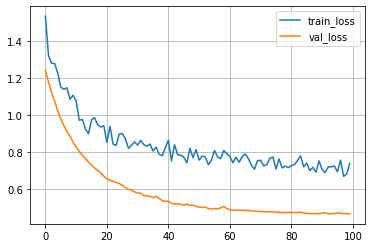

In [24]:
history, sequence_model = run_experiment()

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.grid()
plt.show()

**Note**: To keep the runtime of this example relatively short, we just used a few training examples. This number of training examples is low with respect to the sequence model being used that has 99,909 trainable parameters. You are encouraged to sample more data from the UCF101 dataset using [the notebook](https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb) mentioned above and train the same model.

## Inference

In [25]:
# For inference, we first extract frames from a single video
# and then extract features from those using the pre-trained
# InceptionV3 network.
def extract_features_test(video_name):
    output_dir = video_name.split(".")[0]
    separate_frames([video_name], root_dir="test", 
                    output_dir=output_dir, 
                    frame_count=SEQ_LENGTH, save_interval=10)
    
    frame_paths = sorted(list(paths.list_images(output_dir)))
    features = []
    frames = []
    
    for frame_path in frame_paths:
        frame = keras.preprocessing.image.load_img(frame_path, target_size=(IMG_SIZE, IMG_SIZE))
        frame = keras.preprocessing.image.img_to_array(frame)
        frames.append(frame)
    frames = np.stack(frames)
    features = feature_extractor.predict(frames[None, ...])
    return np.stack(frames), features

# After feature extraction, we are good to pass the
# features to our recurrent model and obtain predictions. 
def sequence_prediction(video_name):
    frames, features = extract_features_test(video_name)
    probabilities = sequence_model.predict(features)[0]
    
    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

# This utility is for visualization. 
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=10)
    return embed.embed_file('./animation.gif')

In [26]:
# We first make sure we are predicting for a video that
# is not broken.
correct_video_names_test = [x for x in test_video_names 
      if x not in broken_video_names_test]

100%|██████████| 1/1 [00:00<00:00, 76.54it/s]


Testing video: v_ShavingBeard_g06_c06.avi


  ShavingBeard: 70.78%
  TennisSwing: 23.82%
  Punch:  3.96%
  PlayingCello:  0.98%
  CricketShot:  0.45%



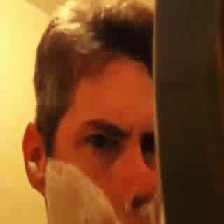

In [27]:
test_video = np.random.choice(correct_video_names_test, 1)[0]
print()
print(f"Testing video: {test_video}")
frames = sequence_prediction(test_video)
to_gif(frames)

## Next steps

* In this example, we made use of transfer learning for extracting meaningful features
from video frames. You could also fine-tune the pre-trained network to notice how that
affects the end results. You may even have better results with a smaller,
higher-accuracy model like [EfficientNetB0](https://arxiv.org/abs/1905.11946).
* Try different combinations of `max_frame_counts` and `save_interval` to observe how
that affects the performance.
* Train on a higher number of classes and see if you are able to get good performance.
* Following [this tutorial](https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub), try a
[pre-trained action recognition model](https://arxiv.org/abs/1705.07750) from DeepMind.
* Rolling-averaging can be useful technique for video classification and it can be
combined with a standard image classification model to infer on videos.
[This tutorial](https://www.pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/)
will help understand how to use rolling-averaging with an image classifier.
* When there are variations in between the frames of a video not all the frames might be equally important to decide its category. In those situations, putting a [self-attention layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention) in the sequence model will likely yield better results. 